In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import cmocean as cmo

# Reload module
import importlib
import parameters as pm 
importlib.reload(pm)

cmap = cmo.cm.balance

dst = xr.open_dataset("population_dataset_NO3_13.nc")
n0 = 30

N = len(dst.kappa)
NT = len(dst.t)
print(N)
print(NT)

NV = len(dst.depth)
# hr2s = 1/3600

print(dst)
hr2s = 1/3600

10
500
<xarray.Dataset> Size: 2GB
Dimensions:  (t: 500, n2: 10, init: 10, depth: 10, ratio: 10, kappa: 10)
Coordinates:
  * t        (t) int64 4kB 0 87 173 260 346 ... 42854 42940 43027 43113 43200
  * n2       (n2) float32 40B 5.0 11.11 17.22 23.33 ... 41.67 47.78 53.89 60.0
  * init     (init) float32 40B 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * depth    (depth) float32 40B 4.0 5.222 6.444 7.667 ... 12.56 13.78 15.0
  * ratio    (ratio) float32 40B 0.05 0.15 0.25 0.35 ... 0.65 0.75 0.85 0.95
  * kappa    (kappa) float32 40B 0.1 0.01668 0.002783 ... 5.995e-08 1e-08
Data variables:
    d1       (t, n2, init, depth, ratio, kappa) float64 400MB ...
    d2       (t, n2, init, depth, ratio, kappa) float64 400MB ...
    m1       (t, n2, init, depth, ratio, kappa) float64 400MB ...
    m2       (t, n2, init, depth, ratio, kappa) float64 400MB ...
    n1       (t, n2, init, depth, ratio, kappa) float64 400MB ...


In [6]:
def get_coords(id, ir, inut, ipop):
    depth = dst.depth.values[id]
    ratio = dst.ratio.values[ir]
    n2 = dst.n2.values[inut]
    pop = dst.init.values[ipop]
    return depth, ratio, n2, pop


def normalize_color2(value, init_biomass):
    c = (value - init_biomass) / init_biomass
    # c = c.clip(-3, 3)
    return c


def reshape_(data, N):
    return np.array(data).reshape(N, -1)

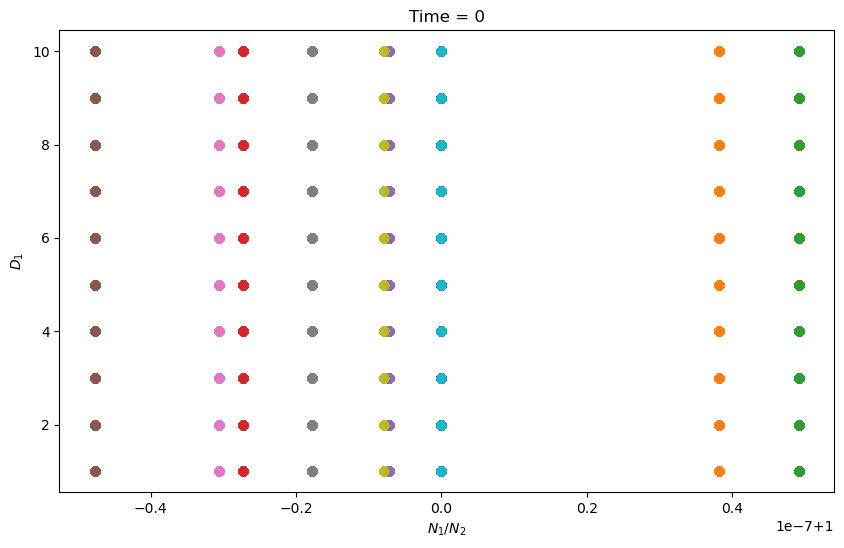

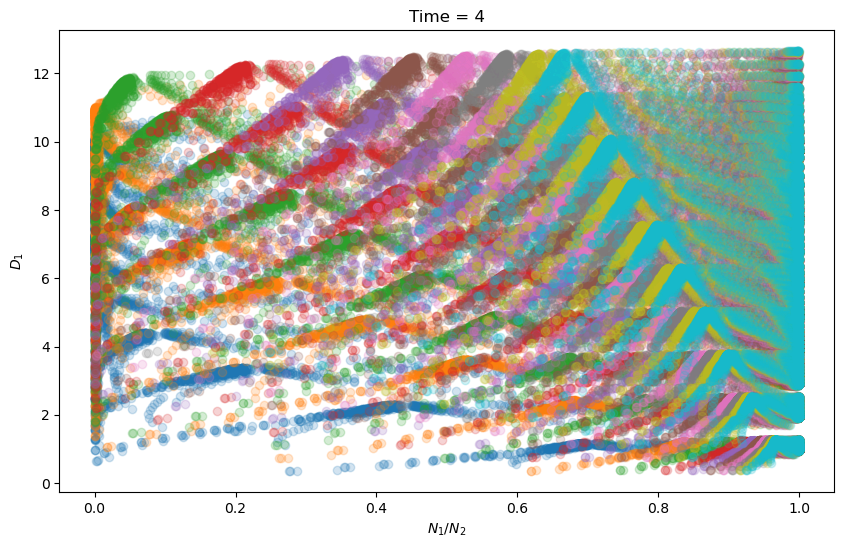

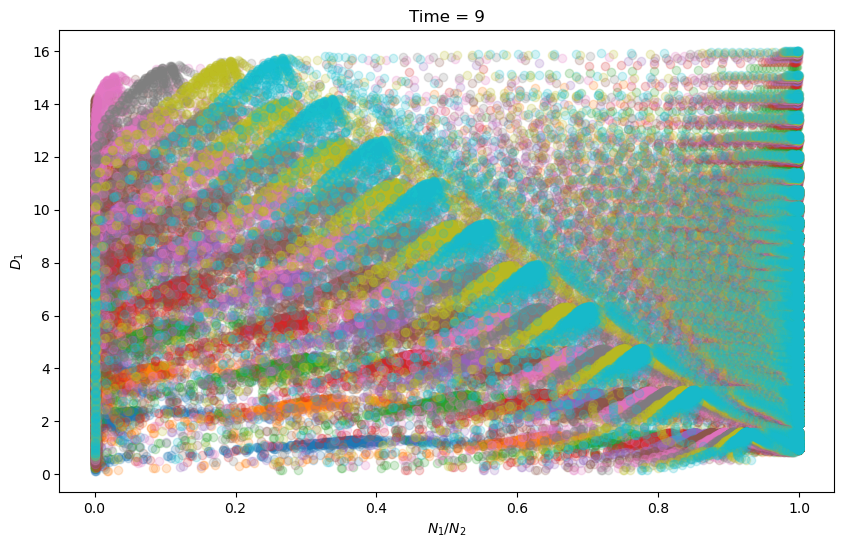

In [7]:
uptake_d =  4.16e-6 * 17 # nutrient uptake rate for diatoms (* 1e6)
uptake_m = 2.23e-6 * 16 

nd_uptake = (uptake_d * dst.init * dst.ratio * dst.depth) / (dst.n2 * dst.kappa)
nd_uptake = 1/nd_uptake


for t in range(0, 500, 200):
    fig = plt.figure(figsize=(10,6))

    for i in range(NV): 
        n1_slice = dst.n1.isel(t=t).isel(n2=i)

     
        d1_slice = dst.d1.isel(t=t).isel(n2=i)*1e-6
        # d1_slice = d1_slice  #/  d1_slice.init

        nd_uptake = (uptake_d * dst.init * dst.ratio * dst.depth) / (dst.n2.values[i] * dst.kappa)
        nd_uptake = nd_uptake.values.flatten()

        d1_slice = d1_slice.values.flatten()

        n2_vec = dst.n2.values[i]*np.ones(len(d1_slice))
        plt.scatter(n1_slice / dst.n2.values[i], d1_slice , label = "d1", alpha=0.2)


        # plt.scatter(n2_vec, nd_uptake, label = "d1", alpha=0.2)

    ax = plt.gca()
    # ax.set_xlabel("Fixed nutrient supply (µmol N / L)")
    ax.set_xlabel("$N_1 / N_2$ ")
    ax.set_ylabel("$D_1 $")

    # ax.set_ylabel("microcystis population (10e6 cells")
    ax.set_title("Time = %d" % (dst.t.values[t]/3600))
    # ax.set_xlabel("Non-dimensionalized nutrient uptake")
    # ax.set_xscale("log")
    # ax.set_yscale("log")

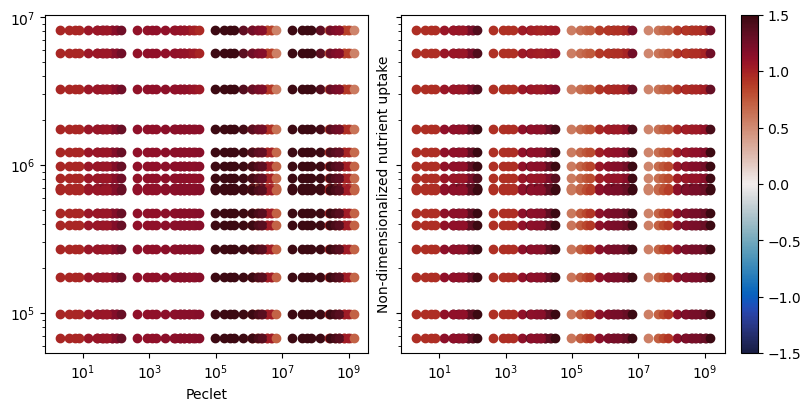

In [ ]:


id = 7
ir = 5
inut = 7 
ipop = 7




# (uptake_d * pop ) /
def calculate_nd_uptake(depth, ratio, n2, pop, kappa):
    nd_uptake =  uptake_d * pop / (n2 * (pm.alpha + pm.beta)) 

    # nd_uptake = (uptake_d * pop *  depth) / (n2 * kappa)
    # nd_uptake = 1/nd_uptake
    return nd_uptake


# nd_uptake = (uptake_d * dst.init * dst.ratio * dst.depth) / (dst.n2 * dst.kappa)


txt = "Depth = %2.2f m,  $N_2$=%d, Init pop=%d" % (depth, n2, pop)




fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()

for inut in range(0, NV, 3):
    for id in range(0, NV, 3):
        for ipop in range(0, NV, 3):
            for ir in range(0, NV, 3):

                depth, ratio, n2, pop = get_coords(id, ir, inut, ipop)
                init_biomass = pop*2e6 
                dst0 = dst.isel(n2=inut, init=ipop, depth=id, ratio=ir, t=400)

                for ik in range(0, NV,3): 
                    BIOMASS_M = dst0.m1.isel(kappa=ik) + dst0.m2.isel(kappa=ik)
                    BIOMASS_M = BIOMASS_M / init_biomass

                    BIOMASS_D = dst0.d1.isel(kappa=ik) + dst0.d2.isel(kappa=ik)
                    BIOMASS_D = BIOMASS_D / init_biomass

                    uptake_star = calculate_nd_uptake(depth, ratio, n2, init_biomass, dst.kappa.values[ik])
                    # beta_star = pm.alpha * ratio * depth/ dst.kappa.values[ik]
                    resupply_star = ratio*depth / dst.kappa.values[ik] # pm.wm * ratio / dst.kappa.values[ik] #n2 / pm.gamma_d  * ratio * depth / dst.kappa.values[ik]

                    uptake_star = np.ones_like(BIOMASS_M) * uptake_star
                    h = axs[0].scatter(resupply_star, uptake_star,  c=BIOMASS_M, cmap=cmo.cm.balance, vmin=-1.5, vmax=1.5)
                    h = axs[1].scatter(resupply_star, uptake_star,  c=BIOMASS_D, cmap=cmo.cm.balance, vmin=-1.5, vmax=1.5)

axs[0].set_xlabel("Peclet")
axs[1].set_ylabel("Non-dimensionalized nutrient uptake")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
plt.colorbar(h)


<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1811765/1263276948.py:26: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("Re($\lambda$)")
/tmp/ipykernel_1811765/1263276948.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/tmp/ipykernel_1811765/1263276948.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')


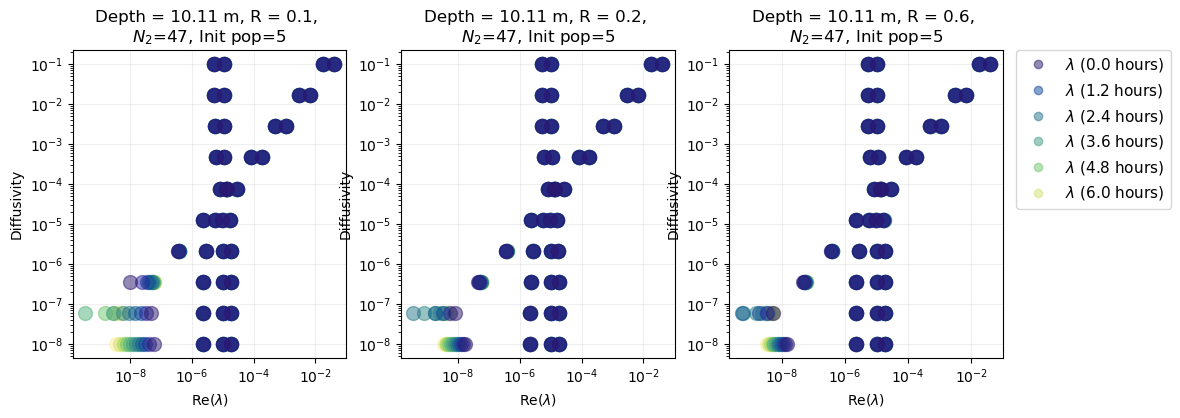

In [8]:
# Snapshot of three time frames 
TIMES = list(range(0, 300, 25)) 

id = 5
ir = 5
inut = 7 
ipop = 4

# Depth = 5.00 m, R = 0.6, Kappa = 2e-04 (interesting)
depth, ratio, n2, pop = get_coords(id, ir, inut, ipop)
h1 = ratio * depth
h2 = depth - h1

# txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)

shapes = ['o', 's', '^', 'x', 'v']
variables = ["M_1", "M_2", "D_1", "D_2", "N_1"]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axs = axs.flatten()
for ax in axs:
    ax.grid(alpha=0.2)
    ax.axhline(y=0, color='k', alpha=0.5)
    ax.axvline(x=0, color='k', alpha=0.5)
    ax.set_ylabel("Diffusivity")
    ax.set_xlabel("Re($\lambda$)")
    ax.set_yscale('log')
    ax.set_xscale('log')
irs = [0, NV//4, NV//2]
for ix, ax in enumerate(axs):
    ir = irs[ix]
    ratio = dst.ratio.values[ir]
    txt = "Depth = %2.2f m, R = %2.1f, \n$N_2$=%d, Init pop=%d" % (depth, ratio, n2, pop)
    ax.set_title(txt)
    for ik in range(0, NV, 1):
        kappa = dst.kappa.values[ik]          
        for it in TIMES: 
            hour = dst.t.values[it]/3600
            m1 = dst.m1.values[it, inut, ipop, id ,ir, ik] # t, n2, init, depth, ratio, kappa
            m2 = dst.m2.values[it, inut, ipop, id ,ir, ik]
            n1 = dst.n1.values[it, inut, ipop, id ,ir, ik]
            d1 = dst.d1.values[it, inut, ipop, id ,ir, ik]
            d2 = dst.d2.values[it, inut, ipop, id ,ir, ik]

            eigenvalues, ev = pm.jacobian_2s(kappa, h1, h2, m1, m2, d1, d2, n1)
            for e, eig in enumerate(eigenvalues):
                if eig.real < 0:
                    eigenvalues[e] = -eig
                    ev[e] = -ev[e]               
            eigenvalues = sorted(eigenvalues)
            vector0 = np.array([m1, m2, n1])
            color = cmo.cm.haline_r(it/max(TIMES))

            for ie, eigenvalue in enumerate(eigenvalues[0:4]):
                # if eigenvalue.real<0:
                #     vector0 = -vector
                # else:
                #     vector0 = vector
                ev0 = ev[ie]/ np.linalg.norm(ev[ie])
                vector0 = vector0/ np.linalg.norm(vector0)
                if eigenvalue.imag != 0:
                    print("Complex eigenvalue!", eigenvalue.imag)
                    ax.plot(abs(eigenvalue.imag), kappa, '*', color=color, alpha=0.5, markersize=10) #, label=r"$\lambda_%d$ (%2.1f hours)" % (ie, hour), )

                if ((it%2) == 0):
                    ax.plot(abs(eigenvalue.real), kappa, 'o', color=color, alpha=0.5, markersize=10) #, label=r"$\lambda_%d$ (%2.1f hours)" % (ie, hour), )
                    # ax2.plot(ev0.dot(vector0), kappa, shapes[ie],  color=color, alpha=0.5)#,  label=r"$V_%d$ (%2.1f hours)" % (ie, hour))
                else:
                    ax.plot(abs(eigenvalue.real), kappa, 'o',  color=color, alpha=0.5, markersize=10)
                    # ax2.plot(ev0.dot(vector0), kappa, shapes[ie],  color=color, alpha=0.5)
                    # print(ev[ie].dot(ev[ie+1])) 

for it in TIMES[::2]:
    hour = dst.t.values[it]/3600
    ax.plot([],[], 'o', alpha=0.5, color = cmo.cm.haline(it/max(TIMES)),  label=r"$\lambda$ (%2.1f hours)" % (hour)) 

ax.legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11,)
fn = txt.replace(",", "_")
# fig.savefig("eigens/%s.png" % fn, dpi=300)



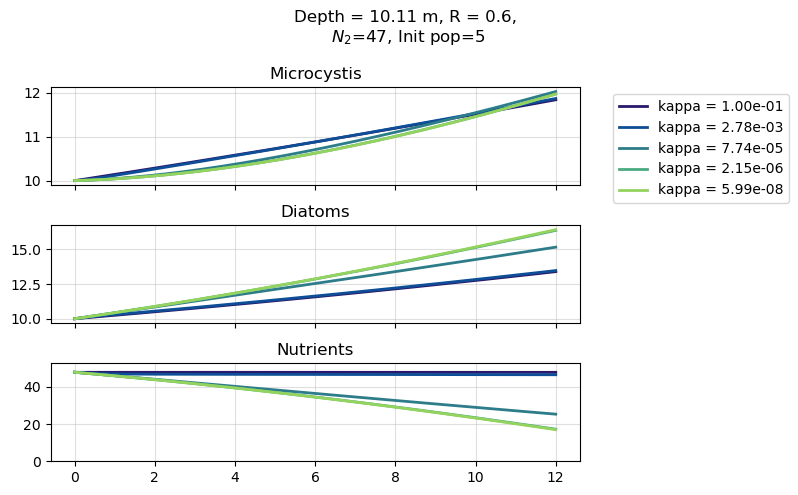

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,5), sharex=True, sharey=False)


for ik in range(0, NV, 2):
    color = cmo.cm.haline(ik/NV)

    total = (dst.m1[:, inut, ipop, id ,ir, ik] + dst.m2[:, inut, ipop, id ,ir, ik])/1e6
    axs[0].plot(dst.t.values/3600, total, 
            color=color,
            linewidth=2,
            label="kappa = %2.2e" % dst.kappa.values[ik])
    axs[1].plot(dst.t.values/3600, dst.d1[:, inut, ipop, id ,ir, ik]/1e6 + dst.d1[:, inut, ipop, id ,ir, ik]/1e6, 
            color=color,
            linewidth=2,
            label="kappa = %2.2e" % dst.kappa.values[ik])

    axs[2].plot(dst.t.values/3600, dst.n1[:, inut, ipop, id ,ir, ik], 
            color=color,
            linewidth=2,
            label="kappa = %2.2e" % dst.kappa.values[ik])
#     print(dst.n1[:, id ,ir, ik].values)
axs[1].set_title("Diatoms")
axs[0].set_title("Microcystis")
axs[2].set_title("Nutrients")
# title = "Ratio = %2.2f, Depth = %2.2f" % (dst.ratio.values[ir], dst.depth.values[id],)
plt.suptitle(txt)

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[2].set_ylim(0, n2*1.1)
for ax in axs:
        ax.grid(alpha=0.4)
plt.tight_layout()

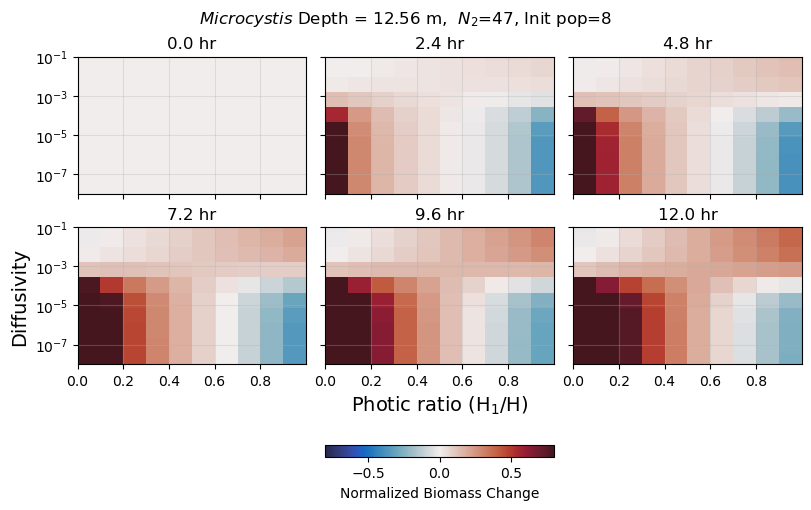

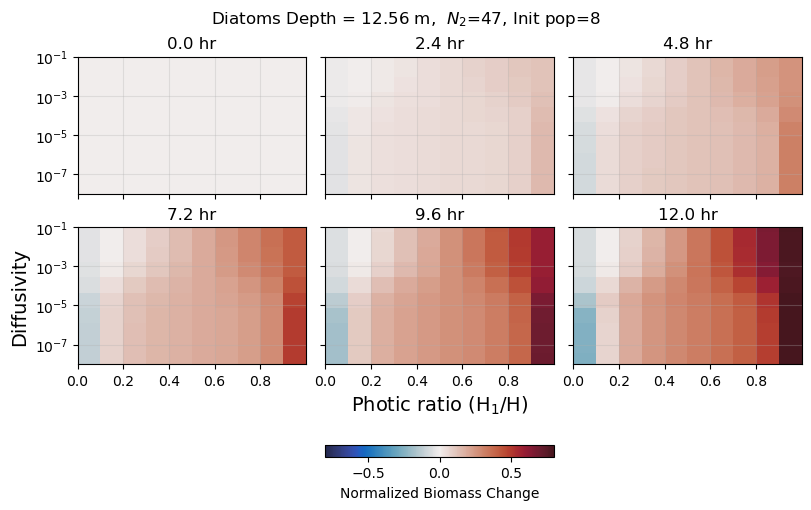

In [11]:


id = 7
ir = 5
inut = 7 
ipop = 7


depth, ratio, n2, pop = get_coords(id, ir, inut, ipop)
txt = "Depth = %2.2f m,  $N_2$=%d, Init pop=%d" % (depth, n2, pop)

init_biomass = pop*2e6 

KAPPA  = dst.kappa.values #[::-1]
RATIO = dst.ratio.values 

dst0 = dst.isel(n2=inut, init=ipop, depth=id)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 5), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
fig.suptitle("Depth = %2.2f" % depth)

for i, it in enumerate([0, 100, 200, 300, 400, 499]):
    axs[i].set_yscale('log')
    BIOMASS_M = dst0.m1[it, :, :] + dst0.m2[it, :, :]
    relative = normalize_color2(BIOMASS_M, init_biomass) #reshape_(BIOMASS_M, N))

    axs[i].set_title("%2.1f hr" % (dst.t.values[it]/3600))

    h = axs[i].pcolormesh(RATIO, KAPPA, relative.T, linewidths=4, alpha=0.95, cmap=cmo.cm.balance, vmin=-8e-1, vmax=8e-1) 
   
plt.colorbar(h, label='Normalized Biomass Change', orientation='horizontal',  pad=0.2, ax=axs[-2])

axs[3].set_ylabel("Diffusivity", fontsize=14)
axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)
text = "Microcystis (%s).png" % txt 
plt.suptitle("$Microcystis$ " +  txt)
for ax in axs:
    ax.grid(alpha=0.3)
    ax.set_ylim(KAPPA.min(), KAPPA.max())
fig.savefig(text)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 5), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
fig.suptitle("Depth = %2.2f" % depth)

for i, it in enumerate([0, 100, 200, 300, 400, 499]):
    axs[i].set_yscale('log')
    BIOMASS_M = dst0.d1[it, :, :] + dst0.d2[it, :, :]
    relative = normalize_color2(BIOMASS_M, init_biomass) #reshape_(BIOMASS_M, N))

    axs[i].set_title("%2.1f hr" % (dst.t.values[it]/3600))

    h = axs[i].pcolormesh(RATIO, KAPPA, relative.T, linewidths=4, alpha=0.95, cmap=cmo.cm.balance, vmin=-8e-1, vmax=8e-1) 
   
plt.colorbar(h, label='Normalized Biomass Change', orientation='horizontal',  pad=0.2, ax=axs[-2])

axs[3].set_ylabel("Diffusivity", fontsize=14)
axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)
text = "Diatoms (%s).png" % txt 
plt.suptitle("Diatoms " +  txt)
for ax in axs:
    ax.grid(alpha=0.3)
    ax.set_ylim(KAPPA.min(), KAPPA.max())
fig.savefig(text)

In [ ]:
# fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
# axs = axs.flatten()

# # norm 
# norm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=0.25)


# def reshape_(data, N):
#     return np.array(data).reshape(N, -1)

# id = 2
# depth = dst.depth.values[id]
# fig.suptitle("Depth = %2.2f" % depth)

# KAPPA  = dst.kappa.values
# RATIO = dst.ratio.values 

# NT = 300 
# for i, it in enumerate(range(1, NT, NT//12)):
#     # color = cmo.cm.haline(it/NT)
#     BIOMASS_M = dst.m1.values[it, id, :, :] + dst.m2.values[it, id, :, :]
#     BIOMASS_D = dst.d1.values[it, id, :, :] + dst.d2.values[it, id, :, :]
#     ratio_biomass = BIOMASS_M / (BIOMASS_D)
#     axs[i].set_yscale('log')

#     axs[i].set_title("%2.1f hr" % (dst.t.values[it]/3600))

#     h = axs[i].pcolormesh(RATIO, KAPPA,
#                 ratio_biomass.T, linewidths=4, alpha=0.95, cmap=cmo.cm.balance, vmin=0, vmax=2) 

# plt.colorbar(h, label=r'$\frac{Microcystis}{Diatoms}$ ', orientation='horizontal',  pad=0.2, ax=axs[-2])

# axs[3].set_ylabel("Diffusivity", fontsize=14)
# axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)
# plt.suptitle("$Microcystis$ / Diatoms (depth = %d)" % depth)
# for ax in axs:
#     ax.grid(alpha=0.3)

In [ ]:
# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7, 5), sharex=True, sharey=True, constrained_layout=True)
# axs = axs.flatten()

# # norm 
# norm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=0.25)


# def reshape_(data, N):
#     return np.array(data).reshape(N, -1)

# id = 10
# depth = dst.depth.values[id]
# fig.suptitle("Depth = %2.2f" % depth)

# KAPPA  = dst.kappa.values
# RATIO = dst.ratio.values 

# NT = 300 
# for i, it in enumerate(range(1, NT, NT//8)):
#     # color = cmo.cm.haline(it/NT)
#     BIOMASS_M = dst.m1.values[it, id, :, :] + dst.m2.values[it, id, :, :]
#     BIOMASS_D = dst.d1.values[it, id, :, :] + dst.d2.values[it, id, :, :] 

#     diff_m = BIOMASS_M - init_biomass
#     diff_d = BIOMASS_D - init_biomass

#     grows = np.zeros_like(BIOMASS_M) + np.nan
#     grows[(diff_m > 0) & (diff_d < 0)] = -1

#     grows[(diff_m < 0) & (diff_d > 0)] = 1

#     h = axs[i].pcolormesh(RATIO, KAPPA,
#                 grows.T, linewidths=4, alpha=0.95, cmap=cmo.cm.haline, vmin=-1, vmax=1) 

# plt.colorbar(h, label=r'MC grow --> D grow', orientation='horizontal',  pad=0.2, ax=axs[-2])

# axs[3].set_ylabel("Diffusivity", fontsize=14)
# axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)
# plt.suptitle("$Microcystis$ / Diatoms (depth = %d)" % depth)
# for ax in axs:
#     ax.grid(alpha=0.3)

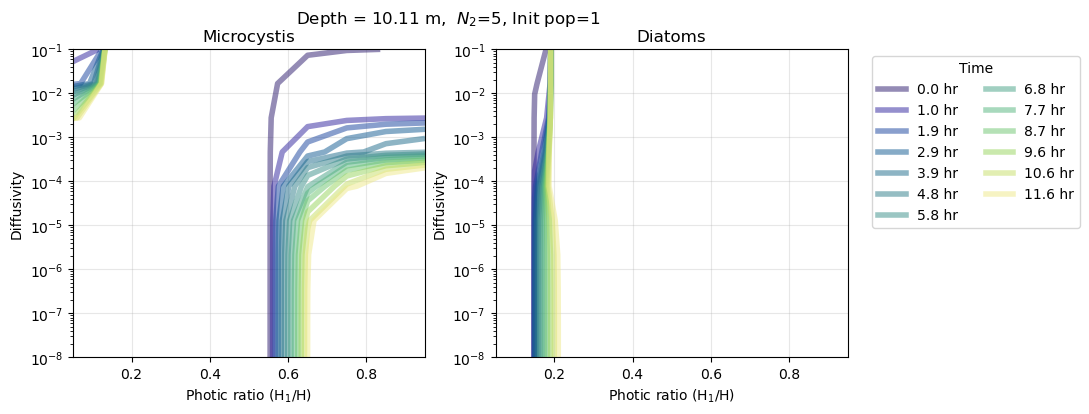

In [14]:

id = 5
ir = 5
inut = 0 
ipop = 0


# Depth = 5.00 m, R = 0.6, Kappa = 2e-04 (interesting)
depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
n2 = dst.n2.values[inut]
pop = dst.init.values[ipop]
txt = "Depth = %2.2f m,  $N_2$=%d, Init pop=%d" % (depth, n2, pop)

init_biomass = pop*2e6 
dst0 = dst.isel(n2=inut, init=ipop, depth=id)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs = axs.flatten()

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel("Photic ratio (H$_1$/H)")
    ax.set_ylabel("Diffusivity")   
    ax.grid(alpha=0.3)


fig.suptitle(txt)

KAPPA  = dst.kappa.values
RATIO = dst.ratio.values 

axs[0].set_title("Microcystis")
axs[1].set_title("Diatoms")

for it in range(1, NT, 40):

    color = cmo.cm.haline(it/NT)
    BIOMASS_M = dst0.m1.values[it, :, :] + dst0.m2.values[it, :, :]
    BIOMASS_D = dst0.d1.values[it, :, :] + dst0.d2.values[it, :, :]
    axs[0].contour(RATIO, KAPPA,
                normalize_color2(BIOMASS_M, init_biomass).T, levels=[0], linewidths=4, alpha=0.5, colors=color) 
    axs[1].contour(RATIO, KAPPA,
                normalize_color2(BIOMASS_D, init_biomass).T, levels=[0], linewidths=4, alpha=0.5, colors=color) 
    axs[1].plot([], [], color=color, label="%2.1f hr" % (dst.t.values[it]/3600), linewidth=4, alpha=0.5)

axs[1].legend(ncols=2, bbox_to_anchor=(1.05, 1), loc='upper left', title="Time")


IndexError: index 15 is out of bounds for axis 0 with size 8

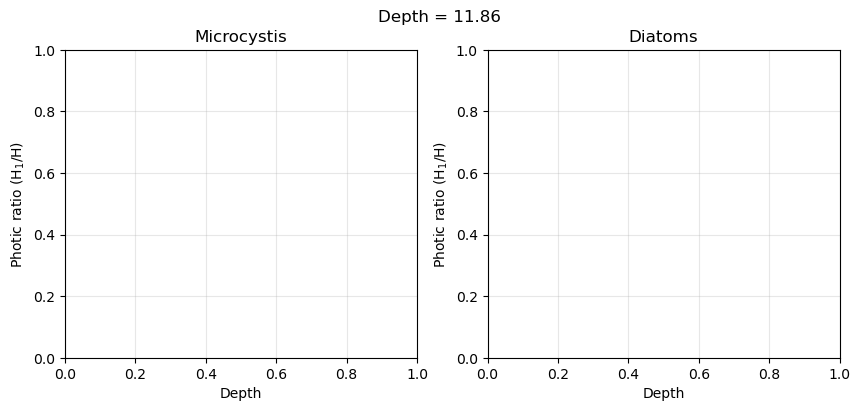

In [ ]:

id = 5
ir = 5
inut = 2 
ipop = 2



depth, ratio, n2, pop = get_coords(id, ir, inut, ipop)


txt = "Depth = %2.2f m,  $N_2$=%d, Init pop=%d" % (depth, n2, pop)

init_biomass = pop*2e6 


# init_biomass = dst.m1.values[0, 0 ,0,0] + dst.m2.values[0, 0 ,0,0]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs = axs.flatten()


for ax in axs:
    # ax.set_yscale('log')
    ax.set_ylabel("Photic ratio (H$_1$/H)")
    ax.set_xlabel("Depth")
    
    ax.grid(alpha=0.3)
# norm 



depth = dst.depth.values[id]
fig.suptitle("Depth = %2.2f" % depth)

KAPPA  = dst.kappa.values
DEPTH = dst.depth.values 
RATIO = dst.ratio.values
axs[0].set_title("Microcystis")
axs[1].set_title("Diatoms")
plt.suptitle("Kappa = %2.2e " % KAPPA[ik])
# (t, depth, ratio, kappa

it = 20 


for ik in range(1, NV, 1):
    color = cmo.cm.haline(ik/NV)
    BIOMASS_M = dst0.m1[it, :, :] + dst0.m2[it, :, :]
    BIOMASS_D = dst0.d1[it, :, :] + dst0.d2[it, :, :]
    axs[0].contour(DEPTH, RATIO,
                normalize_color2(BIOMASS_M).T, levels=[0], linewidths=4, alpha=0.85, colors=color) 
    axs[1].contour(DEPTH, RATIO,
                normalize_color2(BIOMASS_D).T, levels=[0], linewidths=4, alpha=0.85, colors=color) 
    axs[1].plot([], [], color=color, label="kappa = %2.1e" % (KAPPA[ik]), linewidth=4, alpha=0.5)

axs[1].legend(ncols=1, bbox_to_anchor=(1.05, 1), loc='upper left', title="Time")



#     axs[i].set_title("%2.1f hr" % (dst.t.values[it]/3600))

#     h = axs[i].pcolormesh(RATIO, KAPPA, relative.T, linewidths=4, alpha=0.95, cmap=cmo.cm.balance, vmin=-8e-1, vmax=8e-1) 
   
# plt.colorbar(h, label='Normalized Biomass Change', orientation='horizontal',  pad=0.2, ax=axs[-2])

# axs[3].set_ylabel("Diffusivity", fontsize=14)
# axs[-2].set_xlabel("Photic ratio (H$_1$/H)", fontsize=14)
# text = "Diatoms (%s).png" % txt 
# plt.suptitle("Diatoms " +  txt)
# for ax in axs:
#     ax.grid(alpha=0.3)
#     ax.set_ylim(KAPPA.min(), KAPPA.max())
# fig.savefig(text)

In [ ]:
# fig = plt.figure(figsize=(8,3))



# id = 5
# ir = 5
# ik = 1

# colors = ["#164F73", "#75A653", "#F2BC79", "#D9665B"]

# times = dst.t.values/3600
# axp = plt.gca()

# depth = dst.depth.values[id]

# growth_m = 1.08e-5              # 1/s 
# half_sat_m1 = 0.18              # µmol P / L
# max_uptake_m1 = 2.23e-12        # µmol P / cell s 
# half_sat_n1_m = 1.23            # µmol P / L


# ratio = dst.ratio.values[ir]
# h1 = depth*ratio
# h2 = depth - h1

# depth = dst.depth.values[id]
# kappa = dst.kappa.values[ik]



# kappa = dst.kappa.values[ik]
# advection = dst.m2.values[:, id ,ir,ik]*wm/h1 
# diffusion = kappa/h1*(dst.m2.values[:, id ,ir,ik] - dst.m1.values[:, id ,ir,ik])

# m1 = dst.m1.values[:, id ,ir,ik]
# n1 = dst.n1.values[:, id ,ir,ik]

# growth = (growth_m * m1*(n1/(half_sat_m1 + n1)))  #growth_m * dst.m1.values[:, id ,ir,ik] *  dst.n1.values[:, id ,ir,ik] 


# loss = Lm * dst.m1.values[:, id ,ir*2,ik]
# axp.plot(times, advection, '-k', alpha=0.5, label="(+) advection")
# axp.plot(times, -diffusion, '--r', label="(-) diffusion", alpha=0.5)
# axp.plot(times, loss, '-r', label="(-) loss")
# axp.plot(times, growth, '-.k', label="(+) growth")
# gl = growth - loss

# # axp.set_yscale("log")
# axp.set_xlabel("Hours")
# axp.grid( alpha=0.35)
# axp.legend()
# axp.set_title("Depth = %2.2f m, Kappa = %2.1e, Ratio = %2.1f" % (depth, kappa, ratio))


$$ J  = \begin{bmatrix}
    -\frac{\kappa}{H_1} + \alpha \left(\frac{N_1}{\gamma_M + N_1}\right) - L_m & 
    \frac{\kappa}{H_1} +  \frac{w_m}{H_1}  & \alpha M_1 \left( \frac{\gamma_M}{(N_1 + \gamma_M)^2} \right) \\
    \frac{\kappa}{H_2} & -\frac{w_m}{H_2} - \frac{\kappa}{H_2} - L_m 
     & 0  \\
       - U_{m} \left(\frac{N_1}{N_1 + \gamma_{NM}}\right)  & 0  & -\frac{\kappa}{H_1}  - U_M M_1 \left(\frac{\gamma_{NM}}{(N_1 + \gamma_{NM})^2} \right) \\
\end{bmatrix}$$



In [ ]:

    


def steady_state(H, R, kappa, d2, m2, n1):

    # Solution 1:
    d1 = -d2*kappa/(-H*Ld*R + H*R*growth_d*n1 - kappa - wd)
    m1 = (-kappa*m2 - m2*wm)/(-H*Lm*R + H*R*growth_m*n1 - kappa)

    return (d1, m1)






In [ ]:
id = 3
ik = 12
ir = 2

depth = dst.depth.values[id]
ratio = dst.ratio.values[ir]
kappa = dst.kappa.values[ik]

m1 = dst.m1.values[:, id ,ir,ik]
d1 = dst.d1.values[:, id ,ir,ik]
d2 = dst.d2.values[:, id ,ir,ik]
m2 = dst.m2.values[:, id ,ir,ik]
n1 = dst.n1.values[:, id ,ir,ik]
txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e" % (depth, ratio, kappa)

# m1_eq, d1_eq = steady_state(depth, ratio, kappa, d2, m2, n1)
print("depth = %2.2f, ratio = %2.2f, kappa = %1.0e" % (depth, ratio, kappa))

IndexError: index 12 is out of bounds for axis 0 with size 10

In [ ]:
def set_up_phase_axes(fig, axs): 
    axs = axs.flatten()

    gs = axs[1].get_gridspec()

    axs[0].remove()
    axs[1].remove()
    axs[2].remove()

    axs[3].remove()
    axs[4].remove()
    axs[5].remove()

    axphase = fig.add_subplot(gs[0:, 0])
    axp = fig.add_subplot(gs[1:3])
    axn = fig.add_subplot(gs[4:6])
    return axphase, axp, axn


def plot_pop_ax(ax, dst0):
    ax.plot(dst.t.values/3600, dst0.m1.values/1e6, label=r"Microcystis", color='#0F9BF2', linewidth=3)
    ax.plot(dst.t.values/3600, dst0.d1.values/1e6, label=r"Diatoms", color='#5CA612', linewidth=3)
    ax.plot(dst.t.values/3600, dst0.m2.values/1e6, '--', label=r"Bottom Microcystis", color='#0F9BF2', linewidth=1)
    ax.plot(dst.t.values/3600, dst0.d2.values/1e6, '--',  label=r"Bottom Diatoms", color='#5CA612', linewidth=1)
    ax.grid(alpha=0.2)
    ax.set_ylabel("Biomass")
    ax.set_xlabel("Time (hours)")
    ax.legend(loc='upper right')


In [ ]:
import os 
NN = 15



id = 9
ik = 9
ir = 9
inut = 1
ipop = 9

# MM = 3e6
depth, ratio, n2, pop = get_coords(id, ir, inut, ipop)


M0 = pop* 1e6 * 2#890000
M00 = 0 #ipop* 1e6 * 0.8 #-M0 #M0*0.6

dst0 = dst.isel(n2=inut, init=ipop, depth=id, kappa=ik, ratio=ir)


kappa = dst.kappa.values[ik]

txt = "Depth = %2.2f m, R = %2.1f, Kappa = %1.0e \n Init pop=%d, $N_2$=%d" % (depth, ratio, kappa, pop, n2)

x = np.linspace(M00, M0, NN)
y = np.linspace(M00, M0, NN)
X, Y = np.meshgrid(x, y)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharey=False, sharex=False)
fig.suptitle(txt)

axphase, axp, axn = set_up_phase_axes(fig, axs)

axn.plot(dst.t.values/3600, dst0.n1.values , color='#BF0F0F', linewidth=3)
biomass_m = (dst0.m1.values + dst0.m2.values)/1e6
biomass_d = (dst0.d1.values + dst0.d2.values)/1e6

plot_pop_ax(axp, dst0)

# axphase.plot(dst.m1.values[0, id ,ir,ik], dst.d1.values[0, id ,ir,ik], '^', color='k', alpha=0.3, linewidth=4)
axphase.grid(alpha=0.2)
axn.grid(alpha=0.2)

axn.set_ylabel("Surface nutrients")
axn.set_xlabel("Time (hours)")
axn.set_xlim(0, dst.t.values[-1]/3600)
axp.set_xlim(0, dst.t.values[-1]/3600)

axn.hlines(1e-5, 0, dst.t.values[-1]/3600, colors='#BF0F0F', linestyles='dashed', alpha=0.5)

R = dst.ratio.values[ir]
H = dst.depth.values[id]
distances = [] 
for it in range(0, 500, 50):
    
    d1 = dst0.d1.values[it]
    d2 = dst0.d2.values[it]
    m1 = dst0.m1.values[it]
    m2 = dst0.m2.values[it]
    n1 = dst0.n1.values[it]

    U, V = np.zeros_like(X), np.zeros_like(Y)
    # Compute derivatives on grid
    for i in range(NN):
        for j in range(NN):
                f1, f2, f3, f4, f5 = pm.field_at_point_2s(R, H, kappa, X[i,j], m2, Y[i,j], d2, n1, n2=n2)
       
                U[i,j] = f1
                V[i,j] = f3

    axp.plot(dst.t.values[it]/3600, m1/1e6 , 'o', color='#0F9BF2')
    axp.plot(dst.t.values[it]/3600, d1/1e6 , 'o', color='#5CA612')
    axn.plot(dst.t.values[it]/3600, n1 , 'o', color='#BF0F0F')

    axphase.plot([M00, M0], [M00, M0], '--', color='black', alpha=0.15)
    axphase.set_xlabel(r"$M_1$")
    axphase.set_ylabel(r"$D_1$")
    axphase.plot(dst0.m1.values[0:it], dst0.d1.values[0:it], '-', color='#5CA612', alpha=0.3, linewidth=4)
    axphase.plot(m1, d1, 'o', color='#5CA612', markersize=10)
    print(x)
    axphase.streamplot(x, y, U, V,  color="gray")

    angles = np.pi/4 - np.arctan2(V, U)
    print(angles)
    h= axphase.pcolormesh(x, y, angles, cmap=cmo.cm.balance, alpha=0.8, vmin=-np.pi/4, vmax=np.pi/4)
    # plt.colorbar(h)
    # pi/2 -  arctan(V/U)
    d11, m11 = pm.steady_state_2s(ratio, depth, kappa, d2, m2, n1) #steady_state(depth, ratio, kappa, d2, m2, n1)
    if (d11<0) or (m11<0):
        print("Negative steady state!")
        print(m11, d11)
        axphase.plot(m11, d11, 'X', color="#A61281", markersize=10)

    else:
        axphase.plot(m11, d11, 'X', color="#A61281", markersize=10)
    distance = np.sqrt((m11/1e6 - m1/1e6)**2 + (d11/1e6 - d1/1e6)**2)

    distances.append(distance)
    plt.tight_layout()
   

    axphase.set_xlim(M00, M0)
    axphase.set_ylim(M00, M0)
    axphase.hlines(0, M00, M0, colors='k', alpha=0.4)
    axphase.vlines(0, M00, M0, colors='k', alpha=0.4)
    # 

    if 0: 
        plt.show()
        assert(False)
    else: 
        fig.savefig("gif/t_%03d.png" % it, dpi=150)

        axphase.cla()
        for art in list(axphase.lines[1:]):
            art.remove()
        for art in list(axn.lines[1:]):
            art.remove()
        for art in list(axp.lines[4:]):
            art.remove()
plt.close()

if 1:
    folder  = "gif/"
    images = []
    for file_name in sorted(os.listdir(folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(folder, file_name)
            images.append(imageio.imread(file_path))
    txt2 = txt.replace("\n", "_").replace("$", "").replace("\n", "_")
    imageio.mimwrite('time_evolution_%s.gif' % txt2, images, fps=3)
    print(txt)


[0.0000000e+00 1.4285714e+06 2.8571428e+06 4.2857140e+06 5.7142855e+06
 7.1428570e+06 8.5714280e+06 1.0000000e+07 1.1428571e+07 1.2857142e+07
 1.4285714e+07 1.5714285e+07 1.7142856e+07 1.8571428e+07 2.0000000e+07]
[[ 0.7853262   0.7853356   0.7853429   0.7853486   0.78535324  0.7853571
   0.7853604   0.78536314  0.7853655   0.7853676   0.78536946  0.78537107
   0.78537256  0.78537387  0.785375  ]
 [ 0.5035715   0.53888625  0.56646305  0.58856285  0.6066536   0.6217261
   0.6344722   0.64538854  0.6548407   0.6631033   0.6703866   0.67685443
   0.6826359   0.6878345   0.6925339 ]
 [ 0.2605673   0.31919637  0.3667536   0.40593943  0.43869144  0.46641812
   0.49015927  0.51069486  0.52861863  0.54438955  0.5583669   0.57083553
   0.58202386  0.5921171   0.6012666 ]
 [ 0.07028699  0.1388551   0.1968922   0.24633783  0.28877276  0.32546446
   0.35742357  0.38545603  0.41020662  0.43219417  0.45183882  0.46948305
   0.48540816  0.4998467   0.51299226]
 [-0.07304978 -0.00315553  0.05822462  0

/tmp/ipykernel_876689/50362517.py:130: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


Depth = 15.00 m, R = 0.9, Kappa = 1e-08 
 Init pop=10, $N_2$=11


In [ ]:
if 1:
    folder  = "gif/"
    images = []
    for file_name in sorted(os.listdir(folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(folder, file_name)
            images.append(imageio.imread(file_path))
            txt2 = txt.replace("\n", "_").replace("$", "").replace("\n", "_")
    imageio.mimwrite('time_evolution_%s_zoom.gif' % txt2, images, fps=4)
    print(txt)


/tmp/ipykernel_645206/1150636734.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


Depth = 15.00 m, R = 0.9, Kappa = 1e-08 
 Init pop=10, $N_2$=5


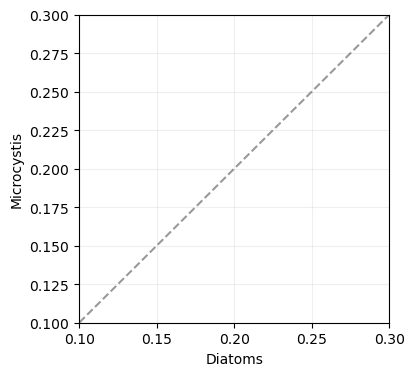

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca() 

NT = 500
id = 10
ir = 18
ik = 19

for iv in range(0, NV, 1):
    
    ir = iv 
    d1 = dst.d1.values[it, id ,ir,ik]
    d2 = dst.d2.values[it, id ,ir,ik] # (time, depth, ratio, kappa) 
    m1 = dst.m1.values[it, id ,ir,ik]
    m2 = dst.m2.values[it, id ,ir,ik]
    n1 = dst.n1.values[it, id ,ir,ik]

    # ax.plot(d11, m11, '^', color=cmo.cm.haline(it/NT), markersize=10)
    # ax.plot(d1, m1, 'o', color=cmo.cm.haline(it/NT), markersize=10)
    ax.plot(dst.d1.values[:,id ,ir,ik]/1e6, dst.m1.values[:,id ,ir,ik]/1e6, alpha=0.85, color=cmo.cm.haline(iv/NV), linewidth=2)

ax.set_ylabel("Microcystis")
ax.set_xlabel("Diatoms")

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(alpha=0.2)
ax.set_xlim(0.1, 0.3)
ax.set_ylim(0.1, 0.3)
ax.plot([0, 0.4], [0, 0.4], '--', color='k', alpha=0.4)
# ax.plot(d1*0.9, d1*1.5)

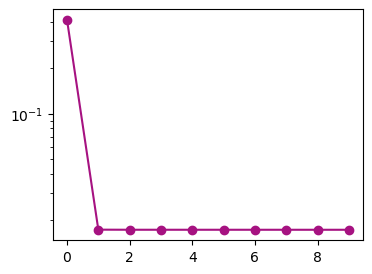

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot( distances, '-o', color='#A61281')
ax.set_yscale('log')

In [ ]:
import imageio
import os

folder  = "gif/"
images = []
for file_name in sorted(os.listdir(folder)):
    if file_name.endswith('.png'):
        file_path = os.path.join(folder, file_name)
        images.append(imageio.imread(file_path))
imageio.mimwrite('time_evolution_%s.gif' % txt, images, fps=3)
print(txt)

/tmp/ipykernel_876689/1301611190.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


Depth = 15.00 m, R = 0.9, Kappa = 1e-08 
 Init pop=10, $N_2$=11


Depth = 9.21 m, Ratio = 0.52

kappa = 4e-02
it = 0, hour = 0.0

kappa = 4e-02
it = 1, hour = 0.0

kappa = 4e-02
it = 2, hour = 0.0

kappa = 4e-02
it = 3, hour = 0.1
theta [102.50450123 102.45087402 102.43747195 102.43234366]
theta [93.37114949 93.33081013 93.32066464 93.31679582]
theta [114.26159966 114.29346321 114.2950156  114.29093495]
theta [71.7317088  71.75243064 71.75062116 71.74455227]
theta [119.99999991 120.01188142 120.01709101 120.02097615]

kappa = 6e-04
it = 0, hour = 0.0

kappa = 6e-04
it = 1, hour = 0.0

kappa = 6e-04
it = 2, hour = 0.0

kappa = 6e-04
it = 3, hour = 0.1
theta [79.14530245 79.2461067  79.34428682 79.43991383]
theta [87.52297777 87.59047151 87.65620138 87.72021543]
theta [144.64987401 144.7648201  144.87680419 144.98590151]
theta [98.3697434  98.4140871  98.45730547 98.49942591]
theta [59.99996935 59.97987647 59.96032471 59.94129431]

kappa = 9e-06
it = 0, hour = 0.0

kappa = 9e-06
it = 1, hour = 0.0

kappa = 9e-06
it = 2, hour = 0.0

kappa = 9e-06
it = 3

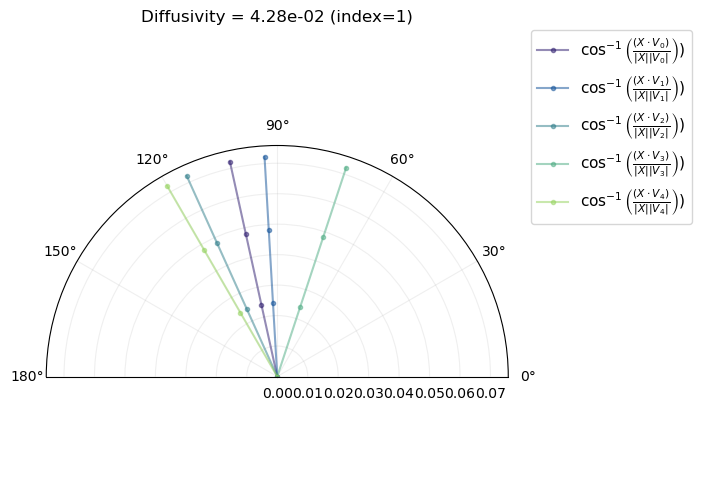

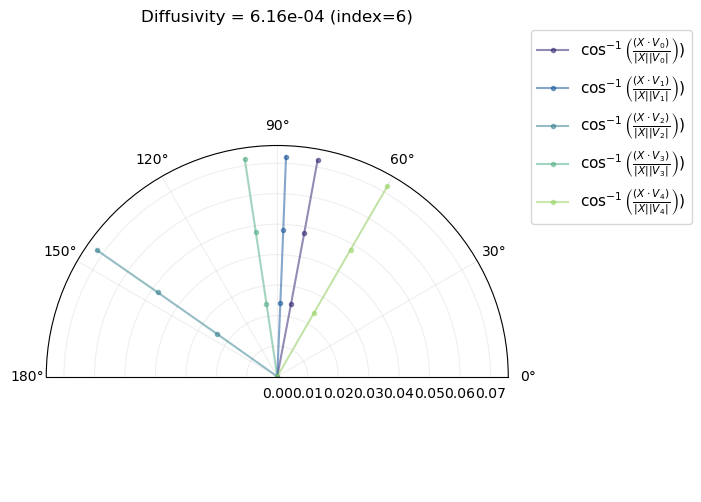

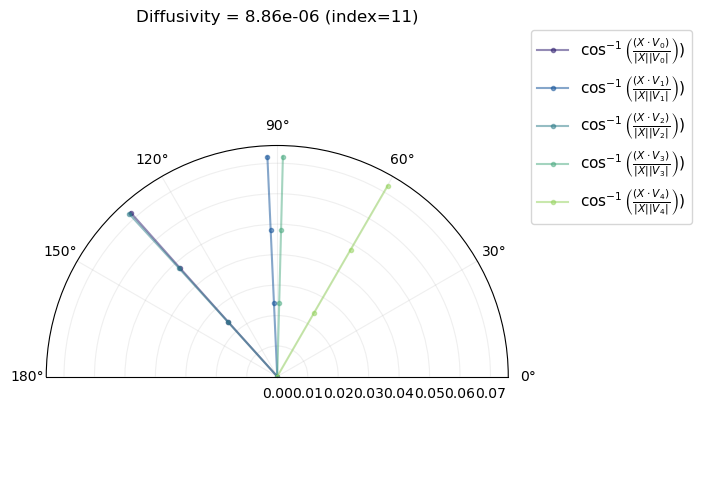

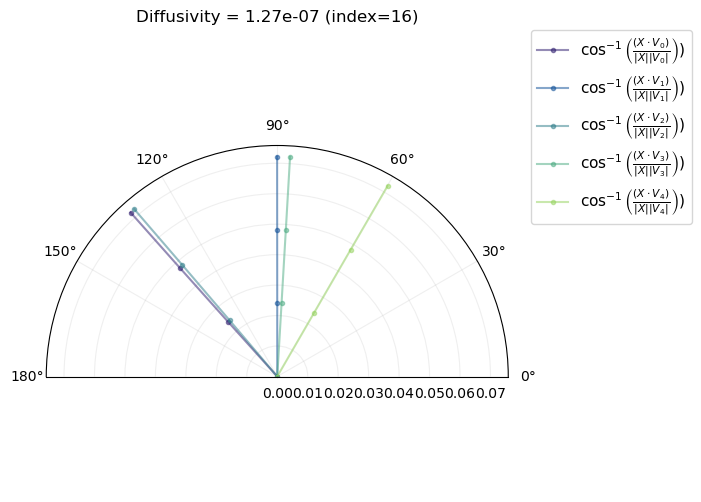

In [ ]:
# Polar plot
TIMES = list(range(0, 4, 1)) 


id = 9
ir = 10
print("Depth = %2.2f m, Ratio = %2.2f" % (dst.depth.values[id], dst.ratio.values[ir]))

hours = [dst.t.values[i]/3600 for i in TIMES]
for ik in range(1, 20, 5):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='polar')

    ax.grid(alpha=0.2)

    ax.set_title("Diffusivity = %2.2e (index=%d)" % (dst.kappa.values[ik], ik))
    kappa = dst.kappa.values[ik]
    
    # d1 = dst.d1.values[0, id ,ir, ik] 
    # d2 = dst.d2.values[0, id ,ir, ik] # (time, depth, ratio, kappa) 
    # m1 = dst.m1.values[0, id ,ir, ik] 
    # m2 = dst.m2.values[0, id ,ir, ik]
    # n1 = dst.n1.values[0, id ,ir, ik] 
    # state_vector0 = np.array([m1, m2, d1, d2, n1])
    theta = np.zeros((len(TIMES), 5))

    for i, it in enumerate(TIMES): 

        hour = dst.t.values[it]/3600
        d1 = dst.d1.values[it, id ,ir, ik]
        d2 = dst.d2.values[it, id ,ir, ik] # (time, depth, ratio, kappa) 
        m1 = dst.m1.values[it, id ,ir, ik]
        m2 = dst.m2.values[it, id ,ir, ik]
        n1 = dst.n1.values[it, id ,ir, ik]
        eigenvalues, ev = pm.jacobian_2s(kappa, h1, h2, m1, m2, d1, d2, n1)
        state_vector = np.array([m1, m2, d1, d2, n1])

        # Iterate through the eigenvectors
        for iv, vector in enumerate(ev): 
            cos0 =  np.dot(state_vector, vector) / (np.linalg.norm(state_vector) * np.linalg.norm(vector)) 
            theta[i, iv]  = np.arccos(cos0)


        print("\nkappa = %1.0e" % kappa)  
        print("it = %d, hour = %2.1f" % (it, hour))

    for c in range(0,5):
        print("theta", np.rad2deg(theta[:,c])) 
        ax.plot(theta[:,c], hours, '.-', color=cmo.cm.haline(c/5), alpha=0.5, label=r'$\cos^{-1} \left( \frac{(X \cdot V_%d)}{ |X| |V_%d|} \right)$)' % (c,c)) # Theta= cos^-1 (u dot v / |v| |u|).
        # ax.plot(hours,theta[:,c], '-o', color=cmo.cm.deep(c/5), alpha=0.5, label=r'$\cos^{-1} \left( \frac{(X \cdot V_%d)}{ |X| |V_%d|} \right)$)' % (c,c)) # Theta= cos^-1 (u dot v / |v| |u|).

    ax.legend(bbox_to_anchor=(1.05, 1), ncols=1, loc='upper left', borderaxespad=0., fontsize=11)
    ax.set_thetamin(0)
    ax.set_thetamax(180)